In [1]:
from mxnet import autograd as ag 
from mxnet import nd
from mxnet import gluon

# 卷积神经网络

![no_padding_no_strides](../image/no_padding_no_strides.gif)
[图片来源](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md)

- 权重w的格式 : w --> output_filter * input_filter * height * width
- 数据data的格式：data --> batch_size * channels * height * width
- 数据的通道channels需和w的input_filter保持一致

当数据为单通道时

In [2]:
w = nd.arange(4).reshape((1,1,2,2))
b = nd.array([1])
data = nd.arange(9).reshape((1,1,3,3))
out = nd.Convolution(data, w, b, kernel=w.shape[2:], num_filter=w.shape[0], stride=(2,2), pad=(1,1))
print(" data: \n" +' ', data, "\n\n w: ", w, "\n\n bias: ", b, "\n\n out:", out)

 data: 
  
[[[[0. 1. 2.]
   [3. 4. 5.]
   [6. 7. 8.]]]]
<NDArray 1x1x3x3 @cpu(0)> 

 w:  
[[[[0. 1.]
   [2. 3.]]]]
<NDArray 1x1x2x2 @cpu(0)> 

 bias:  
[1.]
<NDArray 1 @cpu(0)> 

 out: 
[[[[ 1.  9.]
   [22. 44.]]]]
<NDArray 1x1x2x2 @cpu(0)>


我们可以控制如何移动窗口，和在边缘的时候如何填充窗口。下图演示了 strider=1 和 padding =2
![arbitrary_padding_no_strides](../image/arbitrary_padding_no_strides.gif)

In [3]:
w = nd.arange(8).reshape(1, 2, 2, 2)
b = nd.array([1])
data = nd.arange(18).reshape(1, 2, 3, 3)
out = nd.Convolution(data, w, b, kernel=w.shape[2:], num_filter=w.shape[0])
print(" data: \n" +' ', data, "\n\n w: ", w, "\n\n bias: ", b, "\n\n out:", out)

 data: 
  
[[[[ 0.  1.  2.]
   [ 3.  4.  5.]
   [ 6.  7.  8.]]

  [[ 9. 10. 11.]
   [12. 13. 14.]
   [15. 16. 17.]]]]
<NDArray 1x2x3x3 @cpu(0)> 

 w:  
[[[[0. 1.]
   [2. 3.]]

  [[4. 5.]
   [6. 7.]]]]
<NDArray 1x2x2x2 @cpu(0)> 

 bias:  
[1.]
<NDArray 1 @cpu(0)> 

 out: 
[[[[269. 297.]
   [353. 381.]]]]
<NDArray 1x1x2x2 @cpu(0)>


当数据有多个通道，输出也有需多个通道，那么权重会在每个通道上做卷积

In [4]:
w = nd.arange(16).reshape((2,2,2,2))
data = nd.arange(18).reshape((1,2,3,3))
b = nd.array([1,2])
out = nd.Convolution(data, w, b, kernel=w.shape[2:], num_filter=w.shape[0])
print(' input:', data, '\n\n weight:', w, '\n\n bias:', b, '\n\n output:',out)

 input: 
[[[[ 0.  1.  2.]
   [ 3.  4.  5.]
   [ 6.  7.  8.]]

  [[ 9. 10. 11.]
   [12. 13. 14.]
   [15. 16. 17.]]]]
<NDArray 1x2x3x3 @cpu(0)> 

 weight: 
[[[[ 0.  1.]
   [ 2.  3.]]

  [[ 4.  5.]
   [ 6.  7.]]]


 [[[ 8.  9.]
   [10. 11.]]

  [[12. 13.]
   [14. 15.]]]]
<NDArray 2x2x2x2 @cpu(0)> 

 bias: 
[1. 2.]
<NDArray 2 @cpu(0)> 

 output: 
[[[[ 269.  297.]
   [ 353.  381.]]

  [[ 686.  778.]
   [ 962. 1054.]]]]
<NDArray 1x2x2x2 @cpu(0)>


# 池化层
因为卷积层每次作用在一个窗口， 它对位置很敏感。池化层能够很好的缓解这个问题。它跟卷积类似，每次看一个小窗口， 然后选出窗口里面最大的元素，或者平均元素作为输出。

In [5]:
data = nd.arange(9).reshape((1, 1, 3, 3))
                            
max_pool = nd.Pooling(data, pool_type='max', kernel=(2,2))
avg_pool = nd.Pooling(data, pool_type='avg', kernel=(2,2))
print(' max:', max_pool, '\n avg: ', avg_pool)                            

 max: 
[[[[4. 5.]
   [7. 8.]]]]
<NDArray 1x1x2x2 @cpu(0)> 
 avg:  
[[[[2. 3.]
   [5. 6.]]]]
<NDArray 1x1x2x2 @cpu(0)>


### CNN 从零开始版（Fashion Mnist）

In [6]:
batch_size = 256
weight_scale = 0.01

### 读取数据

In [7]:
def load_data_fashion_mnist(batch_size):
    """Download the fashion mnist dataset and then load into memory."""
    transformer = [gluon.data.vision.transforms.ToTensor()]
    transformer = gluon.data.vision.transforms.Compose(transformer)

    mnist_train = gluon.data.vision.FashionMNIST(train=True)
    mnist_test = gluon.data.vision.FashionMNIST(train=False)
    num_workers = 4

    train_iter = gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                  batch_size, shuffle=True,
                                  num_workers=num_workers)
    test_iter = gluon.data.DataLoader(mnist_test.transform_first(transformer),
                                 batch_size, shuffle=False,
                                 num_workers=num_workers)
    return train_iter, test_iter

In [8]:
train_dataset, test_dataset = load_data_fashion_mnist(batch_size)

### 定义参数

In [9]:
#W1 输入通道 1， 输出通道 20
W1 = nd.random_normal(shape=(20, 1, 5, 5), scale=weight_scale)
b1 = nd.zeros(W1.shape[0])

# W2 输入通道20， 输出通道为50
W2 = nd.random_normal(shape=(50, 20, 3, 3), scale = weight_scale)
b2 = nd.zeros(W2.shape[0])

# 输入 1250 ， 输出 128
W3 = nd.random_normal(shape=(1250, 128),scale=weight_scale)
b3 = nd.zeros(W3.shape[1])

# 输入128， 输出 10
W4 = nd.random_normal(shape=(128, 10), scale=weight_scale)
b4 = nd.zeros(W4.shape[1])

params =[W1, b1, W2, b2, W3, b3, W4, b4]
for param in params:
    param.attach_grad()

我们使用的模型是`LeNet`,两个卷积层，两个全连接层。    
卷积模块通常是“卷积层-激活层-池化层”，然后输出为2D矩阵交给后面的全连接层

In [10]:
def net(X, verbose=False):
    # 第一层卷积
    h1_conv = nd.Convolution(X, W1, b1, kernel=W1.shape[2:], num_filter=W1.shape[0])
    h1_activation = nd.relu(h1_conv)
    h1 = nd.Pooling(h1_activation, pool_type="max", kernel=(2,2), stride=(2,2))
    
    # 第二层卷积
    h2_conv = nd.Convolution(h1, W2, b2, kernel=W2.shape[2:], num_filter=W2.shape[0])
    h2_activation = nd.relu(h2_conv)
    h2 = nd.Pooling(h2_activation, pool_type="max", kernel=(2,2), stride=(2,2))
    h2 = nd.flatten(h2)
    # 第一层全连接
    h3_linear = nd.dot(h2, W3) + b3
    h3 = nd.relu(h3_linear)
    
    #第二层全连接
    h4_linear = nd.dot(h3, W4) + b4
    if verbose:
        print(" 1st conv block:", h1.shape)
        print(" 2nd conv block:", h2.shape)
        print(" 1st dense:", h3.shape)
        print(" 2nd dense:", h4_linear.shape)
        print(" output:", h4_linear.shape)
    return h4_linear

In [11]:
for data, _ in train_dataset:
    net(data, verbose=True)
    break

 1st conv block: (256, 20, 12, 12)
 2nd conv block: (256, 1250)
 1st dense: (256, 128)
 2nd dense: (256, 10)
 output: (256, 10)


### 训练模型

In [12]:

def accuracy(output, label):
    return nd.mean(output.argmax(axis=1)==label.astype('float32')).asscalar()

def evaluate_accuracy(data_iterator, net):
    acc = 0.
    for data, label in data_iterator:
        output = net(data)
        acc += accuracy(output, label)
    return acc /len(data_iterator)

def SGD(params, lr):
    for param in params:
        param[:] = param - lr * param.grad
        
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [13]:
num_epochs = 5
learning_rate = 0.2

import time
start = time.time()
for epoch in range(num_epochs):
    train_loss = 0.
    train_acc = 0.
    for data, label in train_dataset:
        with ag.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        SGD(params, learning_rate/batch_size)
        
        train_loss += loss.mean().asscalar()
        train_acc += accuracy(output, label)
    test_acc = evaluate_accuracy(test_dataset, net)
    print(" Epoch %d. Loss: %f, Train acc %f, Test acc %f" %(
        epoch, train_loss/len(train_dataset), train_acc/len(train_dataset), test_acc))
end = time.time()
print(" Costs %.2f seconds" % (end-start))

 Epoch 0. Loss: 2.301700, Train acc 0.112871, Test acc 0.345020
 Epoch 1. Loss: 1.299875, Train acc 0.511475, Test acc 0.717578
 Epoch 2. Loss: 0.702988, Train acc 0.725770, Test acc 0.771484
 Epoch 3. Loss: 0.578226, Train acc 0.775759, Test acc 0.807324
 Epoch 4. Loss: 0.514234, Train acc 0.803330, Test acc 0.819824
 Costs 204.48 seconds


### CNN-Gluon版

gluon定义网络特别方便，只需要知道输出层，不需要知道输入是多少

In [53]:
from mxnet.gluon import nn
net = nn.Sequential()
with net.name_scope():
    net.add(nn.Conv2D(channels=50, kernel_size=5, activation='relu'))
    net.add(nn.MaxPool2D(pool_size=2, strides=2))
    net.add(nn.Conv2D(channels=20, kernel_size=3, activation='relu'))
    net.add(nn.MaxPool2D(pool_size=2, strides=2))
    net.add(nn.Flatten())
    net.add(nn.Dense(128, activation='relu'))
    net.add(nn.Dense(10))
net.initialize()

### 训练和之前一样

In [54]:
num_epochs = 5
learning_rate = 0.2

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate':learning_rate})
import time
start = time.time()
for epoch in range(num_epochs):
    train_loss = 0.
    train_acc = 0.
    for data, label in train_dataset:
        with ag.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)
        
        train_loss += loss.mean().asscalar()
        train_acc += accuracy(output, label)
    test_acc = evaluate_accuracy(test_dataset, net)
    print(" Epoch %d. Loss: %f, Train acc %f, Test acc %f" %(
        epoch, train_loss/len(train_dataset), train_acc/len(train_dataset), test_acc))
end = time.time()
print(" Costs %.2f seconds" % (end-start))

 Epoch 0. Loss: 1.093293, Train acc 0.590215, Test acc 0.768066
 Epoch 1. Loss: 0.552090, Train acc 0.786846, Test acc 0.828418
 Epoch 2. Loss: 0.458166, Train acc 0.829344, Test acc 0.839746
 Epoch 3. Loss: 0.406198, Train acc 0.850997, Test acc 0.859082
 Epoch 4. Loss: 0.373150, Train acc 0.863132, Test acc 0.876855
 Costs 282.43 seconds


 Epoch 0. Loss: 1.057727, Train acc 0.600310, Test acc 0.783105   
 Epoch 1. Loss: 0.534595, Train acc 0.794138, Test acc 0.818262    
 Epoch 2. Loss: 0.448110, Train acc 0.833411, Test acc 0.844531    
 Epoch 3. Loss: 0.398017, Train acc 0.855264, Test acc 0.868359   
 Epoch 4. Loss: 0.365673, Train acc 0.864672, Test acc 0.862305   
 Costs 196.02 seconds

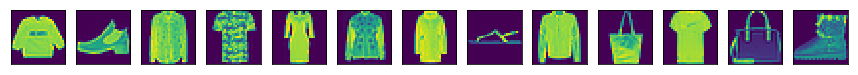

In [16]:
import matplotlib.pyplot as plt
def show_images(images):
    n = images.shape[0]
    _, figs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        figs[i].imshow(images[i].reshape((28,28)).asnumpy())
        figs[i].axes.get_xaxis().set_visible(False)
        figs[i].axes.get_yaxis().set_visible(False)
    plt.show()
mnist_train = gluon.data.vision.FashionMNIST(train=True)
data, label = mnist_train[0:13]
show_images(data)

Note:
- Gluon的数据集FashionMnist的默认格式为（num_examples, height, width, channel), 而我们使用时数据的格式应该为
（nume_examples, channel, height, width),所以可以通过gluon自带的函数进行转换，具体看`load_data_fashion_mnist`函数里的用法
- `help(gdata.vision.transforms.ToTensor)` ToTensor函数会把`(H x W x C)`的形状转换为 `(C x H x W )`
- `gluon.data.ArrayDataset.transform_first` transform_first这个函数特别有用，比如读取了train_mnist，而train_mnist其实是个元组，包含data和label，所以这个transform_first，就只对你的第一个数据data进行变换，label不变


思考题 ：
1. 试试修改改卷积层设定， `filter`数量，`kernel`大小，有什么变化
    - kernel大小在变换之后，基本没有很大的差别，效果基本一致。
2. 试试把池化层从`max`改成`avg`,有什么变化
    - 首先使用两个`avg`池化会比两个`max`效果差，使用一个`max`和一个`avg`效果会在他们之间。5个迭代，‘max'在85%左右，’avg'在82%左右
    - 其次讲讲Polling的作用
        - 卷积神经网络中的卷积层是对图像的一个邻域进行卷积得到图像的邻域特征，亚采样层就是使用pooling技术将小邻域内的特征点整合得到新的特征。pooling确实起到了整合特征的作用。
        - pooling的结果是使得特征减少，参数减少，但pooling的目的并不仅在于此。pooling目的是为了保持某种不变性（旋转、平移、伸缩等），常用的有mean-pooling，max-pooling和Stochastic-pooling三种。 
        - 特征提取的误差主要来自两个方面：（1）邻域大小受限造成的估计值方差增大；（2）卷积层参数误差造成估计均值的偏移。一般来说，mean-pooling能减小第一种误差，更多的保留图像的背景信息，max-pooling能减小第二种误差，更多的保留纹理信息。
    - 所以说`max polling`更多的是提取纹理，细节信息；而`avg`更多的提取背景信息。而我们这边的数据集的图片背景几乎都一样，可以说是没有背景，只有物品。所以这时候两个`max`层效果肯定会好一些。
    
3. 加了卷积层比前面的多层感知机慢了很多，尝试计算下两个模型分别需要多少浮点计算 （ n x m 和 m x k 的矩阵乘法需要浮点运算 2nmk次）

In [63]:
s = time.time()
for i in range(10000*10000):
    a = 8.3 / 8.3
e = time.time()
print('  %f' % (e-s))

  6.853808


1yi 6.566098